In [1]:
import urllib
import re
import numpy as np
import pandas as pd
from astropy.io import ascii
from astropy.table import Table, QTable, Column
from astroquery.sdss import SDSS

import seaborn as sns
import pandas as pd

import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sdss_dr16 = pd.read_csv("dr16_original.csv")
columnsNamesArr = sdss_dr16.columns.values
column_names = list(columnsNamesArr)
print(column_names[1:])

['RA', 'DEC', 'mass', 'host', 'log_ml', 'log_l', 'log_m', 'host_mass', 'host_ra', 'host_dec', 'host_distance', 'objid']


In [3]:
host_known_dr16 = sdss_dr16['host']
ra_host_dr16 = sdss_dr16['host_ra']
dec_host_dr16 = sdss_dr16['host_dec']
host_dist_dr16 = sdss_dr16['host_distance']
objid_known_dr16 = sdss_dr16['objid']

In [4]:
querylist_dr16 = []
radial_dist_2 = 150
max_size_2 = 800
for i in range(len(objid_known_dr16)):
    ra_2 = ra_host_dr16[i]
    dec_2 = dec_host_dr16[i]
    arcmin_2 =  radial_dist_2/(host_dist_dr16[i]*1000)  *360/(2*np.pi)*3600/60 # arcmin
    arcsec_to_pc_2 = host_dist_dr16[i] * 1e6 / 3600 * 2 * np.pi / 360
    mag_calc_2 = 5*np.log10((host_dist_dr16[i]*1e6/10))
   
    query_temp_2 = f"select p.objID, p.ra, p.dec, p.g, p.i, p.r, p.u, p.z, p.type, p.petroR50_r, p.petroR90_r, p.fracDeV_r, p.deVRad_r, p.expRad_r, z1.z as photo_z, z1.zErr as photo_z_err, p.expAB_r, w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro\
        from photoObj as p JOIN Photoz as z1 on p.objID = z1.objID JOIN WISE_xmatch as a on a.sdss_objid = p.objID JOIN WISE_allsky as w on w.cntr = a.wise_cntr, dbo.fGetNearbyObjEq({ra_2},{dec_2},{arcmin_2}) as n \
        where p.objID = n.objID and p.type = 3 and p.g - p.i BETWEEN 0.7 and 1.6 and p.u - p.z BETWEEN 2 and 4 and p.g - p.z BETWEEN 0.7 and 1.9 and p.u - p.g BETWEEN 0.9 and 2.4 and p.z - w.w1mpro BETWEEN 1 AND 2.8 and p.z - w.w2mpro BETWEEN 1.2 AND 2.9 and p.z - w.w3mpro BETWEEN 1.1 AND 6.1 and p.z - w.w4mpro BETWEEN 3.5 and 9.5 and p.r - {mag_calc_2} > -19 and (p.fracDeV_r *  p.deVRad_r + (1 - p.fracDev_r) * p.expRad_r) * {arcsec_to_pc_2} < {max_size_2}"
    querylist_dr16.append(query_temp_2)
    
print(querylist_dr16[0])

select p.objID, p.ra, p.dec, p.g, p.i, p.r, p.u, p.z, p.type, p.petroR50_r, p.petroR90_r, p.fracDeV_r, p.deVRad_r, p.expRad_r, z1.z as photo_z, z1.zErr as photo_z_err, p.expAB_r, w.w1mpro, w.w2mpro, w.w3mpro, w.w4mpro        from photoObj as p JOIN Photoz as z1 on p.objID = z1.objID JOIN WISE_xmatch as a on a.sdss_objid = p.objID JOIN WISE_allsky as w on w.cntr = a.wise_cntr, dbo.fGetNearbyObjEq(187.4448598,8.000469819,30.085298460778343) as n         where p.objID = n.objID and p.type = 3 and p.g - p.i BETWEEN 0.7 and 1.6 and p.u - p.z BETWEEN 2 and 4 and p.g - p.z BETWEEN 0.7 and 1.9 and p.u - p.g BETWEEN 0.9 and 2.4 and p.z - w.w1mpro BETWEEN 1 AND 2.8 and p.z - w.w2mpro BETWEEN 1.2 AND 2.9 and p.z - w.w3mpro BETWEEN 1.1 AND 6.1 and p.z - w.w4mpro BETWEEN 3.5 and 9.5 and p.r - 31.1700540879359 > -19 and (p.fracDeV_r *  p.deVRad_r + (1 - p.fracDev_r) * p.expRad_r) * 83.09706494217447 < 800


In [5]:
objid_list_dr16 = [] 
ra_list_dr16 = [] 
dec_list_dr16 = []
obj_per_search_dr16 = []
petro_r50_list_dr16 = []
petro_r90_list_dr16 = []
fracdev_list_dr16 = []
fracexp_list_dr16 = []
devrad_list_dr16 = []
exprad_list_dr16 = []
r_mag_list_dr16 = []
g_mag_list_dr16 = []
i_mag_list_dr16 = []
u_mag_list_dr16 = []
z_mag_list_dr16 = []
z_list_dr16 = []
z_err_list_dr16 = []
w1_list_dr16 = []
w2_list_dr16 = []
w3_list_dr16 = []
w4_list_dr16 = []
axis_ratio_list_dr16 = []

for i in range(len(objid_known_dr16)):
    results = SDSS.query_sql(querylist_dr16[i], timeout = 240)
    print(results)
    if results == None:
        print('Nothing for index', i)
        obj_per_search_dr16.append(int(0))
    else:
        objid_list_dr16.extend(results['objID'])  
        ra_list_dr16.extend(results['ra'])
        dec_list_dr16.extend(results['dec']) 
        petro_r50_list_dr16.extend(results['petroR50_r'])
        petro_r90_list_dr16.extend(results['petroR90_r'])
        fracdev_list_dr16.extend(results['fracDeV_r'])
        fracexp_list_dr16.extend(1 - results['fracDeV_r'])
        devrad_list_dr16.extend(results['deVRad_r'])
        exprad_list_dr16.extend(results['expRad_r'])
        r_mag_list_dr16.extend(results['r'])
        g_mag_list_dr16.extend(results['g'])
        i_mag_list_dr16.extend(results['i'])
        u_mag_list_dr16.extend(results['u'])
        z_mag_list_dr16.extend(results['z'])
        z_list_dr16.extend(results['photo_z'])
        z_err_list_dr16.extend(results['photo_z_err'])
        w1_list_dr16.extend(results['w1mpro'])
        w2_list_dr16.extend(results['w2mpro'])
        w3_list_dr16.extend(results['w3mpro'])
        w4_list_dr16.extend(results['w4mpro'])
        axis_ratio_list_dr16.extend(results['expAB_r'])
        obj_per_search_dr16.append((len(results['objID'])))

objid_dr16 = np.array(objid_list_dr16)
ra_dr16 = np.array(ra_list_dr16)
dec_dr16 = np.array(dec_list_dr16)
petro_r50_dr16 = np.array(petro_r50_list_dr16)
petro_r90_dr16 = np.array(petro_r90_list_dr16)
fracdev_dr16 = np.array(fracdev_list_dr16) 
fracexp_dr16 = np.array(fracexp_list_dr16) 
devrad_dr16 = np.array(devrad_list_dr16) 
exprad_dr16 = np.array(exprad_list_dr16) 
r_mag_dr16 = np.array(r_mag_list_dr16) 
g_mag_dr16 = np.array(g_mag_list_dr16)
i_mag_dr16 = np.array(i_mag_list_dr16)
u_mag_dr16 = np.array(u_mag_list_dr16)
z_mag_dr16 = np.array(z_mag_list_dr16)
g_i_mag_dr16 = g_mag_dr16 - i_mag_dr16
z_dr16 = np.array(z_list_dr16)
z_err_dr16 = np.array(z_err_list_dr16)
w1_dr16 = np.array(w1_list_dr16)
w2_dr16 = np.array(w2_list_dr16)
w3_dr16 = np.array(w3_list_dr16)
w4_dr16 = np.array(w4_list_dr16)
axis_ratio_dr16 = np.array(axis_ratio_list_dr16)

       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661976011538737  187.84180628333 7.70845080673563 ... 14.937 11.698  8.732
1237661971723583604 187.596363199666 7.54305951505265 ... 12.987 11.875  7.871
1237661971723518157 187.550881151663 7.69647657047258 ... 14.362 10.593  8.407
1237661971723583996 187.614805623494 7.55712684373998 ... 15.105  12.34  8.674
1237661971723583595 187.593363774619 7.65786196520973 ... 15.157 12.227  8.693
1237661971723518618 187.506973120602 7.61808975256641 ... 15.461 12.543  9.171
1237661971723387129 187.233566975887 7.69229283836923 ... 14.561 12.579  9.151
1237661971723452622 187.402957258256 7.67583871697486 ... 15.252 12.519  9.143
1237661971723518385  187.44926944844 7.58431166517807 ... 15.854  12.45   9.02
1237661971723387058  187.14549687402 7.60346570979195 ... 13.915 10.457  9.244
                ...              ...              ..

C:\Users\Home\anaconda3\lib\site-packages\astropy\table\table.py:3488: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237655126083174663 184.854987047775 5.56575077159208 ... 14.326 10.907  8.439
1237655126083174699 184.907453463322 5.58831216637256 ... 14.454 11.068  8.645
1237655126083108948  184.70642924936  5.5876182769553 ... 14.793 12.433  8.916
1237655126083109090 184.824553782913 5.54088872092451 ... 14.916 11.664  8.883
1237654606410219580 184.644023280493 5.74105135138903 ... 12.688 11.317  8.668
1237654606410154201 184.609940765237 5.83812972489734 ... 13.361  11.02  9.034
1237654606410219674  184.72210666564 5.64525169136681 ... 13.476 11.991  8.744
1237654606410219665 184.712620349194 5.72088176742192 ... 13.821 12.354  9.169
1237655126619914321 184.584786279305  5.8560126648181 ... 14.368 12.044  9.104
1237655126083043536 184.655326097334 5.60539811587675 ... 13.904 10.312  8.831
                ...              ...              ..

       objID               ra              dec        ... w2mpro w3mpro w4mpro
------------------- ---------------- ---------------- ... ------ ------ ------
1237661815485694057 190.585691704491 11.3880381979483 ... 14.176 11.013  8.961
1237658628623171804 190.668607269621 11.4755313722636 ... 14.014 10.501  8.114
1237661816022630599  190.73377625801 11.6207092650763 ... 14.384 11.043  8.491
1237658628623106196 190.542616772997 11.4535946627273 ... 15.477 12.212   9.14
1237661948646326354 190.531356622972 11.5939031816788 ... 15.413 12.365  9.077
1237661816022630579 190.712992066362 11.6211263758452 ... 15.335 12.384  9.038
1237661815485562947 190.315555367971 11.3872402227306 ... 11.221 10.759  8.388
1237658628623040605 190.469098690058 11.4282529853463 ... 12.873 12.148  9.134
1237661815485563078 190.325022626739 11.3580920615889 ... 13.815 11.492  8.565
1237661815485694008 190.489183622902 11.3823069905596 ... 14.098 12.733  8.923
                ...              ...              ..

In [6]:
#calculate size of objects given distance of the original it is found near and abs mag
b0=0
r_pc_list_dr16 = []
mv_r_list_dr16 = []
distance_list_dr16 = []
host_galaxy_list_dr16 = []
for i in range(len(host_known_dr16)):
    b1 = b0 + int(obj_per_search_dr16[i])
    #size
    r50_arcsec_dr16 = fracdev_dr16[b0:b1]*devrad_dr16[b0:b1] + fracexp_dr16[b0:b1]*exprad_dr16[b0:b1] 
    r50_pc_dr16 = r50_arcsec_dr16*host_dist_dr16[i]*1e6/3600 * 2*np.pi /360
    r_pc_list_dr16.extend(r50_pc_dr16)
    #abs mag of obj
    mv_r_dr16 = r_mag_dr16[b0:b1] - 5*np.log10((host_dist_dr16[i]*1e6/10))
    mv_r_list_dr16.extend(mv_r_dr16)
    #distance of galaxies according to the host galaxies
    obj_search_dr16 = obj_per_search_dr16[i]
    distance_list_dr16.extend([host_dist_dr16[i]]*obj_search_dr16)
    #host galaxy
    host_galaxy_list_dr16.extend([host_known_dr16[i]]*obj_search_dr16)
    b0 = b1
distance_dr16 = np.array(distance_list_dr16)    
mv_r_dr16 = np.array(mv_r_list_dr16)
r_pc_dr16 = np.array(r_pc_list_dr16)
host_galaxy_list_dr16 = np.array(host_galaxy_list_dr16)

In [7]:
# calculate the index's of known galaxies
index_1= []
for i in range(len(objid_known_dr16)):
    index_1a = np.where(objid_known_dr16[i] == objid_dr16)[0]
    if len(index_1a) > 0:
        index_1.extend(index_1a)  
    else:
        c1 = 0
index_known_dr16 = np.array(index_1)

# objid_known_dr16 = objid_known_dr16.tolist()
objid_known_dr16 = np.array(objid_known_dr16)

In [8]:
# index of unknown objects
objid_notknown_dr16 = [x for x in objid_dr16 if not x in objid_known_dr16]
index_1b = []
for i in range(len(objid_notknown_dr16)):
    index_1c = np.where(objid_notknown_dr16[i] == objid_dr16)[0]
    if len(index_1c) > 0 :
        index_1b.extend(index_1c)
    else:
        c1 = 0    
index_unknown_dr16 = np.array(index_1b)

In [9]:
concentration_index_dr16 = petro_r50_dr16/petro_r90_dr16

In [10]:
# Labelling each index as known or possible contaminant galaxies
category_array_dr16 = np.zeros(len(objid_dr16))
for i in range(len(objid_dr16)):
    if i in index_known_dr16:
        category_array_dr16[i] = 0
    elif i in index_unknown_dr16:
        category_array_dr16[i] = 1
    else:
        category_array_dr16[i] = 99

category_dr16 = []
for i in range(len(objid_dr16)):
    if category_array_dr16[i] == 0:
        category_dr16.append('Known galaxies')
    elif category_array_dr16[i] == 1:
        category_dr16.append('Possible contaminants')
    else:
        category_dr16.append('nope')
        
category_dr16 = np.array(category_dr16)

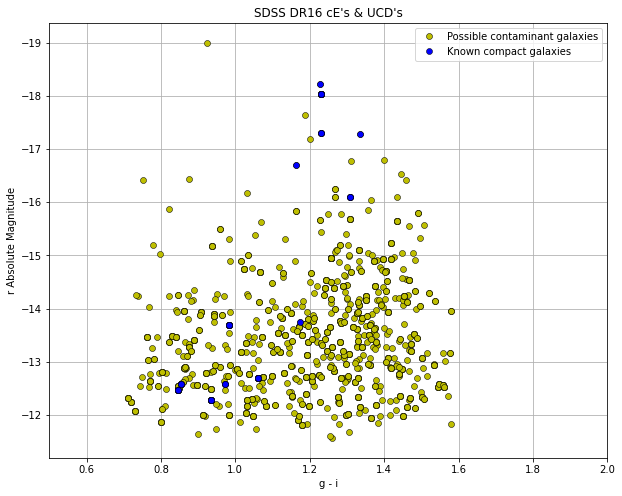

In [11]:
fig1 = plt.figure(figsize=(10,8))

plt.plot(g_i_mag_dr16,mv_r_dr16, 'yo', label = 'Possible contaminant galaxies', markeredgecolor= 'black', markeredgewidth =0.5 , markersize=6)

plt.xlabel('g - i')
plt.ylabel('r Absolute Magnitude')
plt.xlim(0.5,2)
# plt.ylim(-19,-12)
plt.title("SDSS DR16 cE's & UCD's")

plt.plot(g_i_mag_dr16[index_known_dr16],mv_r_dr16[index_known_dr16], 'bo', label = 'Known compact galaxies', markeredgecolor = 'black', markeredgewidth = 0.5, markersize=6)
# plt.plot(g_i_mag_dr7[index_unknown_dr7],mv_r_dr7[index_unknown_dr7], 'ro', label = 'Knsown compact galaxies', markeredgecolor = 'black', markeredgewidth = 0.5, markersize=6)
plt.gca().invert_yaxis()
plt.grid()
plt.legend(loc="upper right")
# plt.savefig('SDSS DR7 cE & UCD.pdf')

In [12]:
print('Total objects (including duplicates):',len(objid_dr16))
objid_filtered_dr16 = []
[objid_filtered_dr16.append(x) for x in objid_dr16 if x not in objid_filtered_dr16]
print('Unique objects:',len(objid_filtered_dr16))
objid_unique_dr16 = np.unique(objid_dr16)

Total objects (including duplicates): 1516
Unique objects: 515


In [13]:
# finding index of each unique object
index_unique = []
index_b = []
for i in range(len(objid_filtered_dr16)):
    index_c = []
    index_e = []
    
    index_b = np.where(objid_filtered_dr16[i] == objid_dr16)[0]

    index_b = np.array(index_b)

    index_c.extend(index_b)

    index_e.append(index_c[0])

    
    if len(index_c) > 1:
        index_unique += index_e
    else:
        index_unique += index_c
        
index_unique = np.array(index_unique)

In [14]:
# make a link to sdss for each object
link_dr16 = []
for i in range(len(index_unique)):
    url = 'http://skyserver.sdss.org/dr16/en/tools/explore/Summary.aspx?id=' + str(objid_dr16[index_unique][i])
    link_dr16.append(url)

In [15]:
# dictionary of lists  
dict = {'objid': objid_dr16[index_unique], 'ra': ra_dr16[index_unique], 'dec': dec_dr16[index_unique], 'g-i': g_mag_dr16[index_unique] - i_mag_dr16[index_unique], 'u-g': u_mag_dr16[index_unique] - g_mag_dr16[index_unique], 'u-z': u_mag_dr16[index_unique] - z_mag_dr16[index_unique], 'g-z': g_mag_dr16[index_unique] - z_mag_dr16[index_unique], 'g-r': g_mag_dr16[index_unique] - r_mag_dr16[index_unique],'z-w1':z_mag_dr16[index_unique] - w1_dr16[index_unique],'z-w2':z_mag_dr16[index_unique] - w2_dr16[index_unique],'z-w3':z_mag_dr16[index_unique] - w3_dr16[index_unique],'z-w4':z_mag_dr16[index_unique] - w4_dr16[index_unique], 'concentration_index': concentration_index_dr16[index_unique], 'photo_z': z_dr16[index_unique], 'frac_dev': fracdev_dr16[index_unique], 'host_galaxy': host_galaxy_list_dr16[index_unique], 'distance': distance_dr16[index_unique], 'axis_ratio': axis_ratio_dr16[index_unique], 'category': category_dr16[index_unique], 'radius': r_pc_dr16[index_unique], 'magnitude': mv_r_dr16[index_unique], 'u_mag': u_mag_dr16[index_unique], 'g_mag': g_mag_dr16[index_unique], 'i_mag': i_mag_dr16[index_unique], 'r_mag': r_mag_dr16[index_unique], 'z_mag': z_mag_dr16[index_unique],'w1': w1_dr16[index_unique], 'w2': w2_dr16[index_unique],'w3': w3_dr16[index_unique], 'w4': w4_dr16[index_unique], 'link': link_dr16} 

df = pd.DataFrame(dict) 
    
# saving the dataframe 
df.to_csv('photometric_search_dr16.csv') 

In [16]:
df_dr16 = pd.read_csv("photometric_search_dr16.csv")
columnsNamesArr1 = df_dr16.columns.values
column_names1 = list(columnsNamesArr1)
print(column_names1[1:])

['objid', 'ra', 'dec', 'g-i', 'u-g', 'u-z', 'g-z', 'g-r', 'z-w1', 'z-w2', 'z-w3', 'z-w4', 'concentration_index', 'photo_z', 'frac_dev', 'host_galaxy', 'distance', 'axis_ratio', 'category', 'radius', 'magnitude', 'u_mag', 'g_mag', 'i_mag', 'r_mag', 'z_mag', 'w1', 'w2', 'w3', 'w4', 'link']


In [17]:
plt.rcParams.update({'font.size': 20})

KeyError: 'spec_z'

<Figure size 720x576 with 0 Axes>

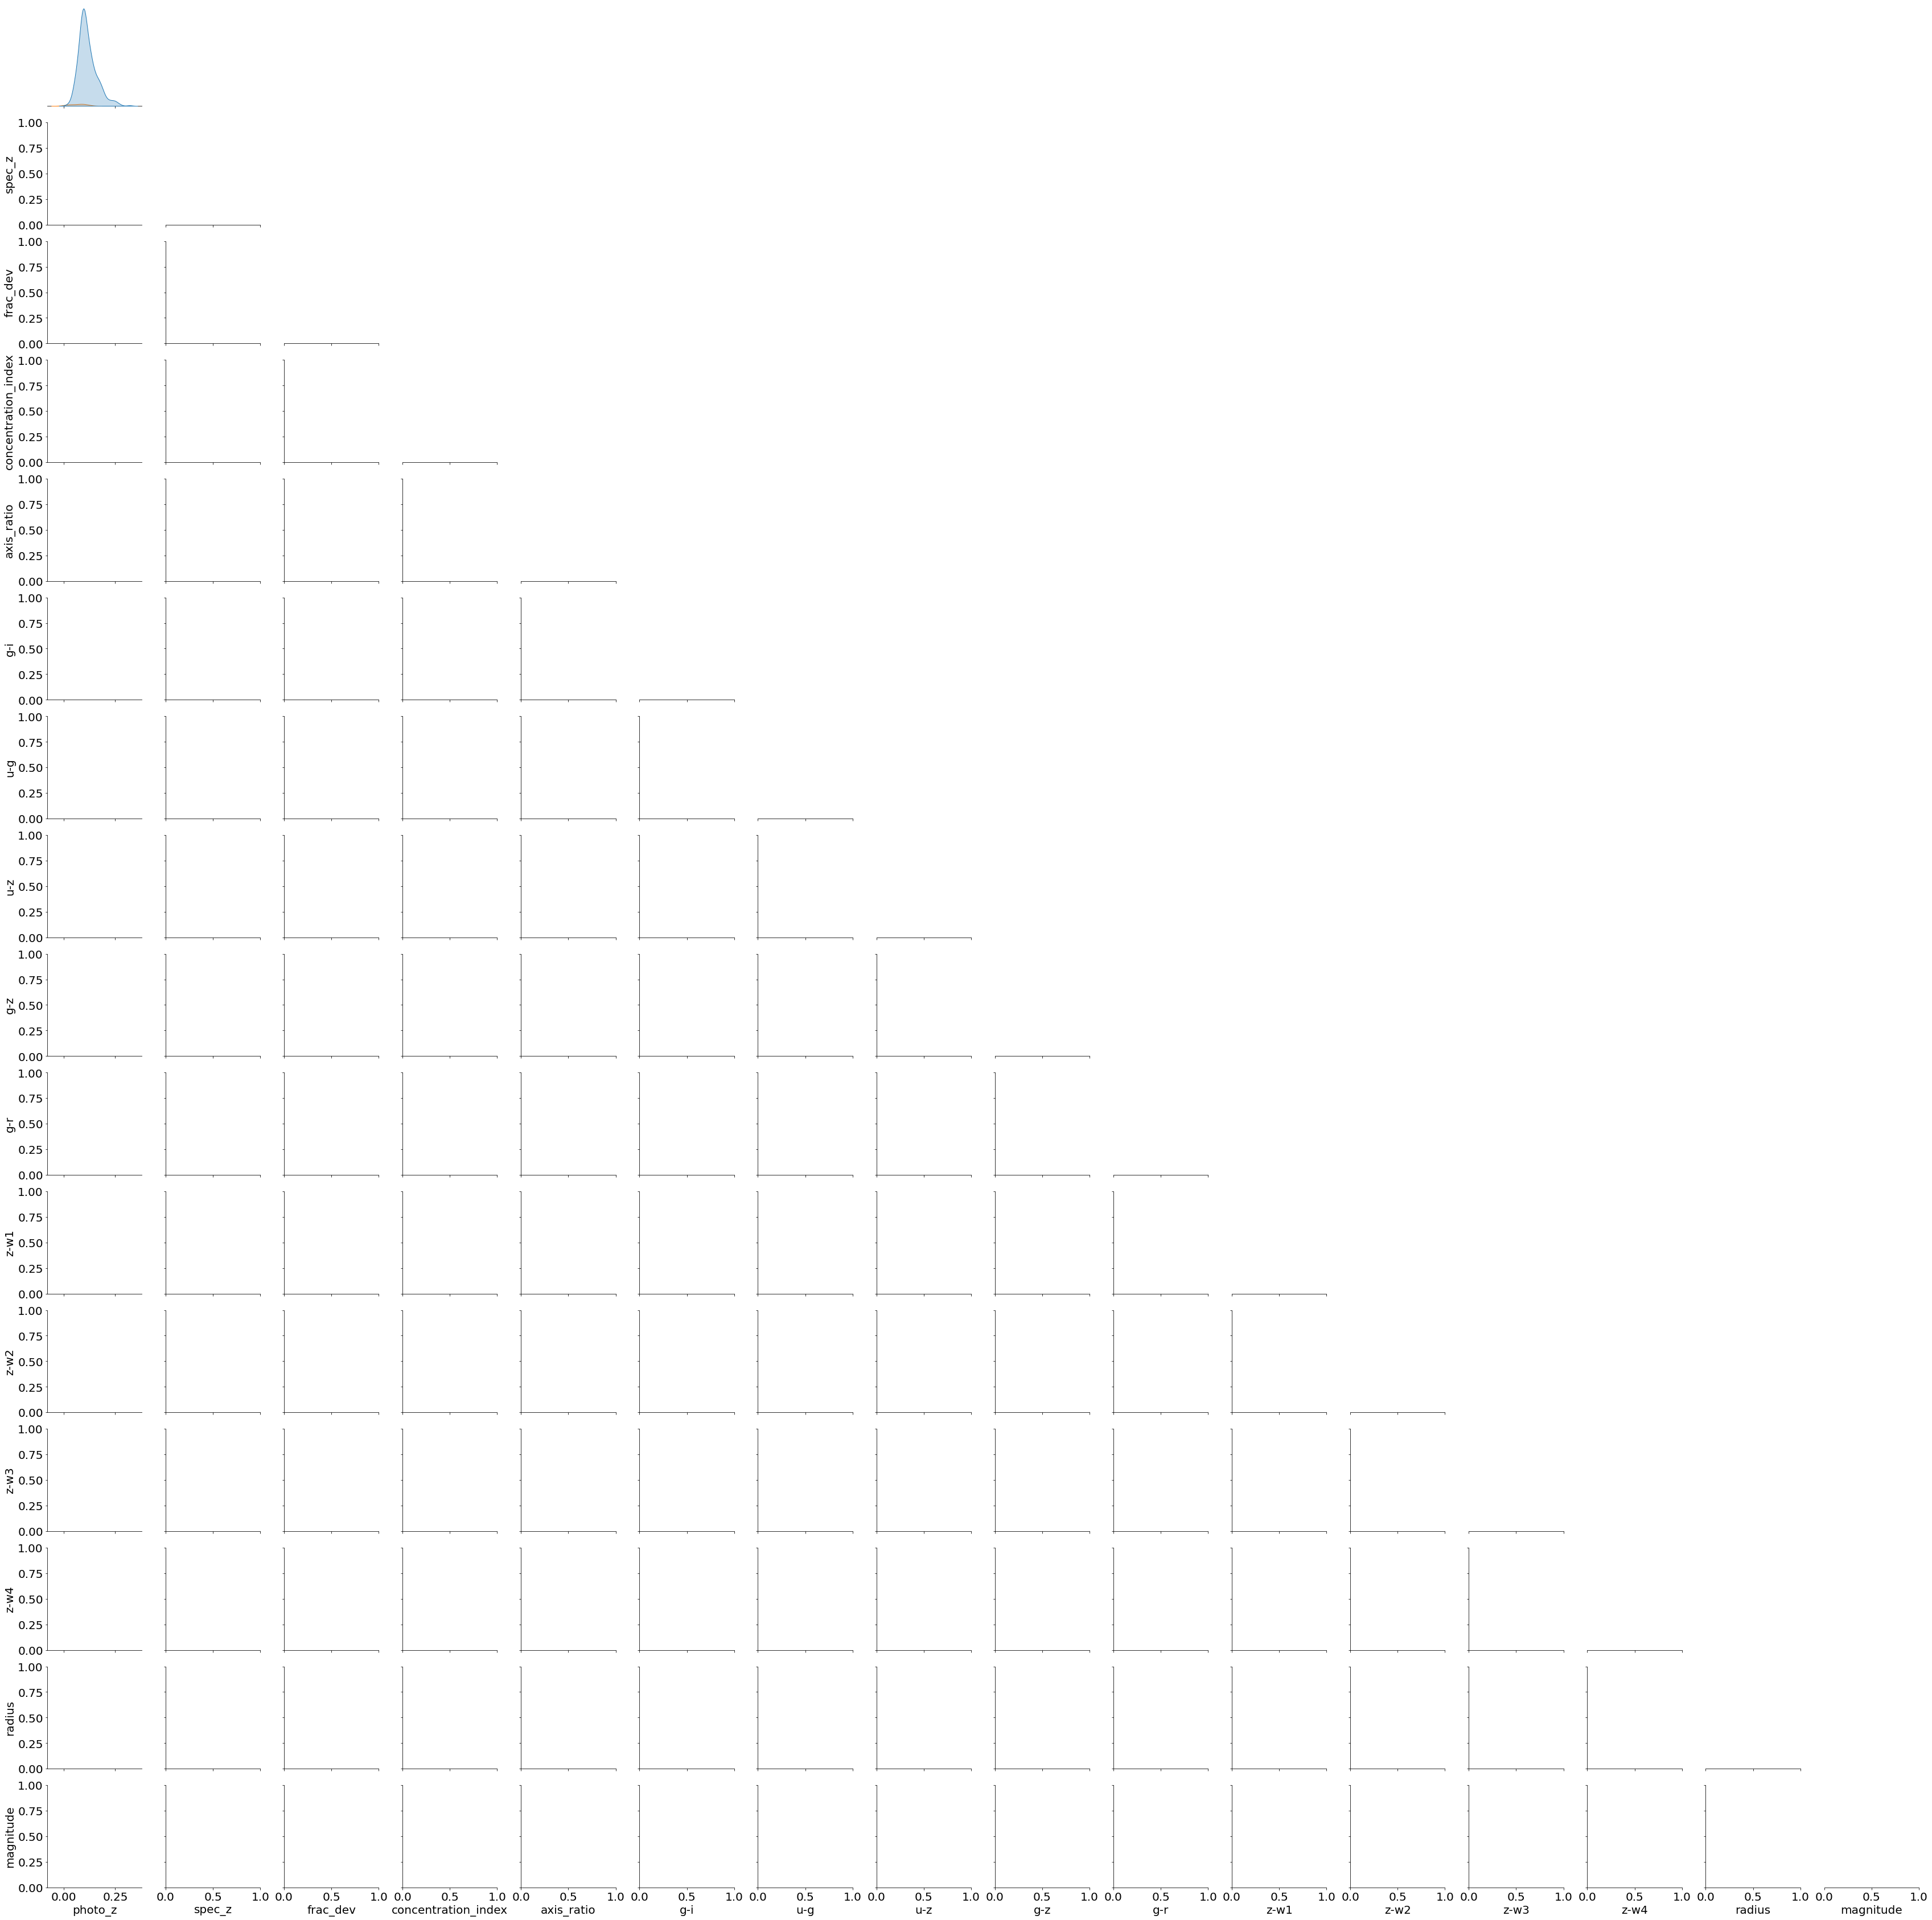

In [18]:
# %matplotlib qt
fig1 = plt.figure(figsize=(10,8))
# sns.set_context("paper", font_scale=2)
# sns.set(font_scale = 1.5)
sns.pairplot(df_dr16, 
             vars = ['photo_z', 'spec_z', 'frac_dev', 'concentration_index', 'axis_ratio', 'g-i', 'u-g', 'u-z', 'g-z','g-r','z-w1', 'z-w2', 'z-w3', 'z-w4','radius','magnitude'],  hue="category",
             corner=True,
             diag_kind = 'kde', 
             plot_kws = {'alpha': 0.5, 's': 80, 'edgecolor': 'k'},
             height=3);
plt.savefig('pairplot_spec_dr16.pdf')
# Title 
plt.suptitle('SDSS DR16 pairplots', 
             size = 30);